<a href="https://colab.research.google.com/github/merveenoyan/example_notebooks/blob/main/ChatGPT_Prompt_Generator_using_Transformers_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training ChatGPT prompt generator

In this notebook, I will walk you through how to train the ChatGPT prompt generator, which is essentially BART model fine-tuned on ChatGPT prompts dataset. 
We will then push it to Hugging Face Hub for easy inference.

If you want an even gentler introduction to how text generation works, you can check out [task page for text generation](https://huggingface.co/tasks/text-generation).

In [ ]:
# let's install transformers, datasets and huggingface_hub
! pip install transformers datasets
# install huggingface_hub if you want to version experiments
! pip install huggingface_hub
# we also need to install git-lfs to host our model
!apt install git-lfs

We are going to use BART model. This model can be used to generate one sequence from another, which can be used to summarize, paraphrase or translate texts too!
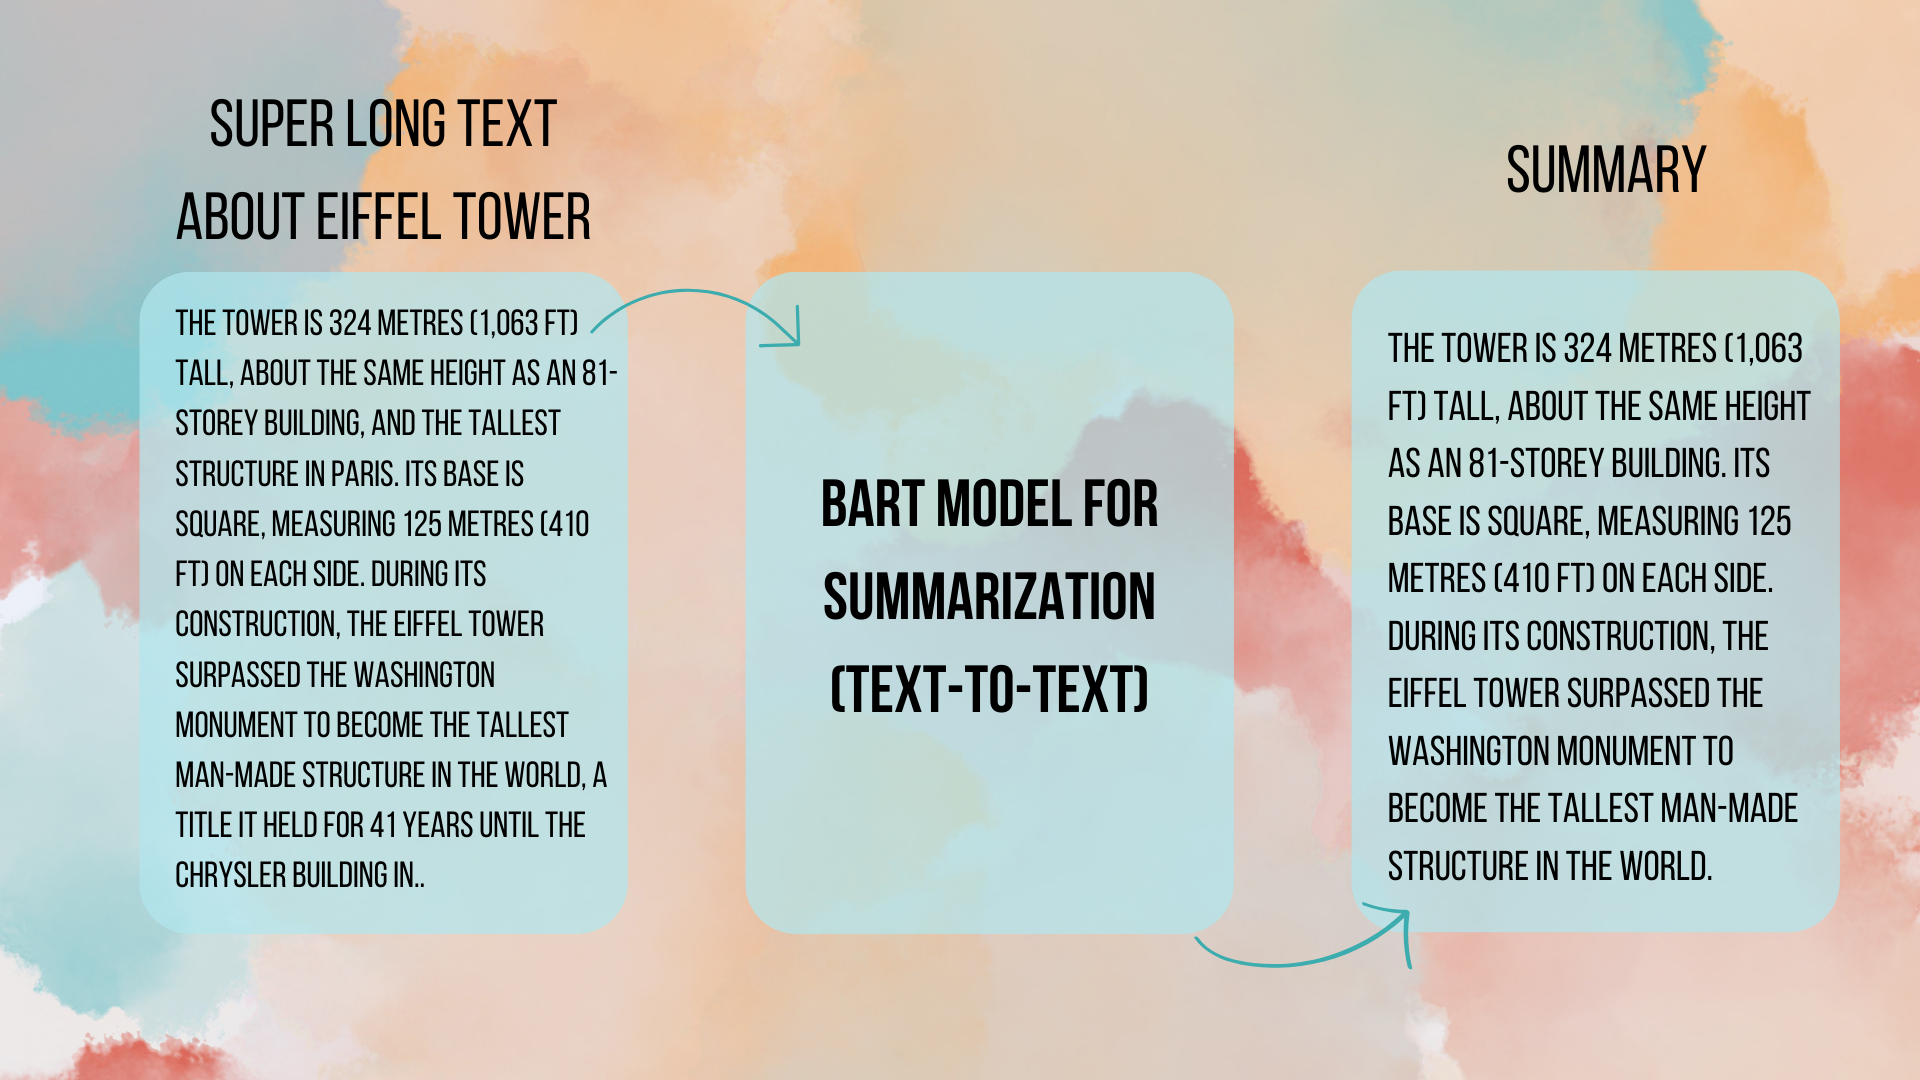

In [2]:
model_checkpoint = "facebook/bart-large"

We will now load the datasets using `datasets` library and look at an example from the dataset. We will try to generate `prompt` from a given `act`, so whenever user inputs a persona, we will generate the prompt that will make ChatGPT become that persona.

In [3]:
from datasets import load_dataset, load_metric

our_dataset = load_dataset("fka/awesome-chatgpt-prompts")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/fka___csv/fka--awesome-chatgpt-prompts-ef221bc5e9b6cd53/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
our_dataset["train"][1]

{'act': 'English Translator and Improver',
 'prompt': 'I want you to act as an English translator, spelling corrector and improver. I will speak to you in any language and you will detect the language, translate it and answer in the corrected and improved version of my text, in English. I want you to replace my simplified A0-level words and sentences with more beautiful and elegant, upper level English words and sentences. Keep the meaning same, but make them more literary. I want you to only reply the correction, the improvements and nothing else, do not write explanations. My first sentence is "istanbulu cok seviyom burada olmak cok guzel"'}

We will load the tokenizer of the model and preprocess the dataset. Tokenizer is essentially dividing sentences into smaller pieces and mapping it to numbers, which can be understood by the model. 

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [6]:
max_input_length = 512
max_target_length = 512


def preprocess_function(examples):
    inputs = [doc for doc in examples["act"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["prompt"], max_length=max_target_length, truncation=True
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [11]:
# we can use `map` method to preprocess our dataset with the datasets function
tokenized_datasets = our_dataset.map(preprocess_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3581: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


We will load the model with a sequence-to-sequence generation head on top of it, as in, as said above, it's used to learn and generate one sequence from another.

In [7]:
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model = TFAutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [8]:
# set out hyperparameters for training
batch_size = 4
learning_rate = 2e-5
weight_decay = 0.01
num_train_epochs = 5

In [9]:
# data collators are used to create batches from the dataset
# it's just an additional preprocessing dataset
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np")
generation_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, return_tensors="np", pad_to_multiple_of=128)

Since this dataset doesn't have a separate validation set, we have to create it ourselves using `datasets`' `train_test_split`method. This will create another dataset dictionary with our sets inside.

In [12]:
split_set = tokenized_datasets["train"].train_test_split(test_size=0.2)

In [13]:
split_set

DatasetDict({
    train: Dataset({
        features: ['act', 'prompt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 114
    })
    test: Dataset({
        features: ['act', 'prompt', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 29
    })
})

We now have to wrap our datasets into `tf.data.Dataset` for Tensorflow model to handle our data natively. For this, we use `prepare_tf_dataset` method, and we will pass our splits separately and prepare our training and validation sets. 

In [14]:
train_dataset = model.prepare_tf_dataset(
    split_set["train"],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=data_collator,
)

validation_dataset = model.prepare_tf_dataset(
    split_set["test"],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=data_collator,
)

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


We will now create our optimizer. You can use native optimizers of Tensorflow too!

In [15]:
from transformers import AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=learning_rate, weight_decay_rate=weight_decay)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


We will now train our model, we can use TensorBoard to track our experiments.

In [16]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir="./model_save/logs")

model.fit(
    train_dataset, validation_data=validation_dataset, epochs=5,
    callbacks = [tensorboard_callback]
)

Epoch 1/5
28/28 [==============================] - 77s 910ms/step - loss: 6.3670 - val_loss: 3.2462
Epoch 2/5
28/28 [==============================] - 13s 481ms/step - loss: 3.5143 - val_loss: 2.7551
Epoch 3/5
28/28 [==============================] - 14s 491ms/step - loss: 3.0299 - val_loss: 2.5620
Epoch 4/5
28/28 [==============================] - 14s 500ms/step - loss: 2.9364 - val_loss: 2.7830
Epoch 5/5
28/28 [==============================] - 14s 499ms/step - loss: 2.7877 - val_loss: 2.4972


## Let's push our model to 🤗Hub! 
This follows token-based authentication, so you can go to your Hugging Face account and get your token from https://huggingface.co/settings/tokens. Make sure it's a token with write access.

In [17]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


We have to push our tokenizer along with our model as it's the preprocessor of the model and is later used for inference. When we push our model, it will also create a model card that contains information on our model and environment. 

In [18]:
tokenizer.push_to_hub("merve/bart-example")
model.push_to_hub("merve/bart-example")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

tf_model.h5:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

## Let's infer 🤩

We can infer in two ways, one convenient way is to use `pipeline` function, which abstracts away many processes for us.
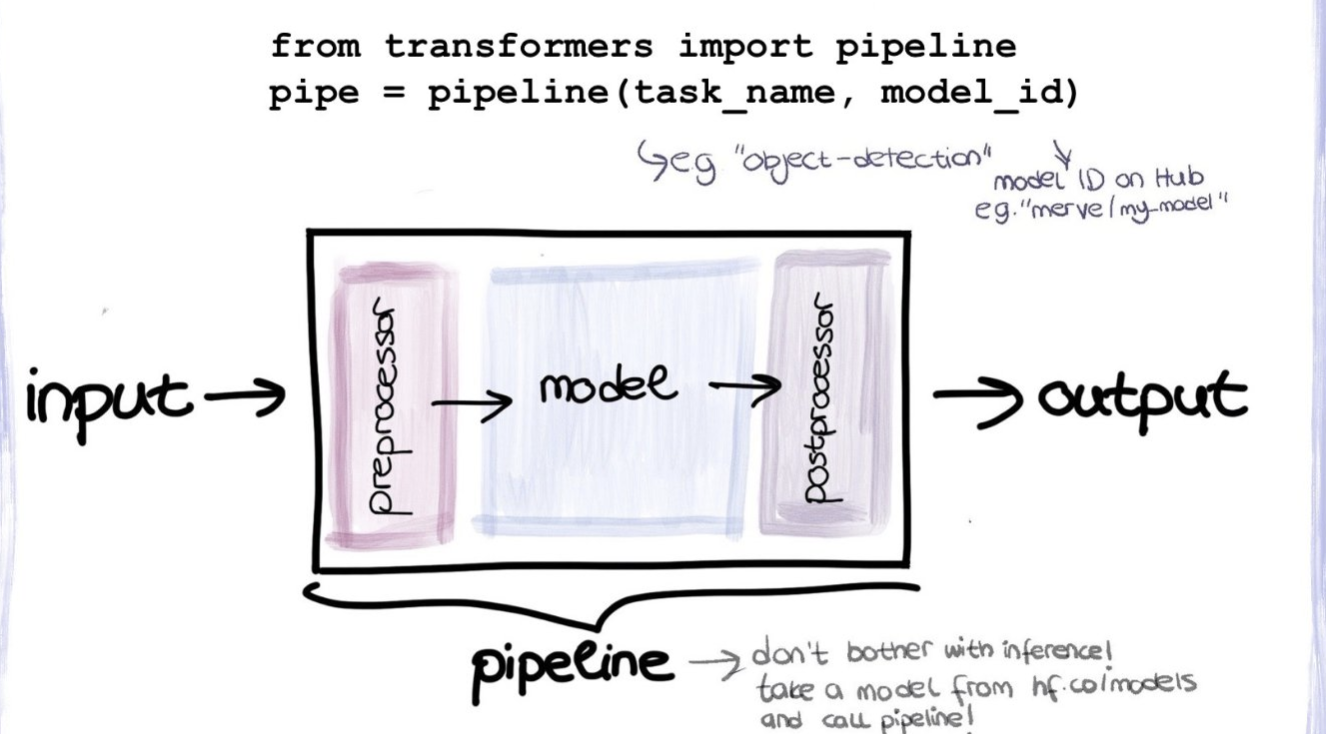

In [19]:
from transformers import pipeline
text2text_generator = pipeline("text2text-generation", model = "merve/bart-example")


All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at merve/bart-example.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [22]:
text2text_generator("personal trainer")

[{'generated_text': 'I want you to act as a personal trainer. I will provide you with'}]

I want more control over my output and it's length, so I can go beyond abstraction and set `max_length`to 200 so that I can have a longer prompt. 

In [25]:
from transformers import BartForConditionalGeneration, BartTokenizer

example_english_phrase = "data scientist"
batch = tokenizer(example_english_phrase, return_tensors="tf")
generated_ids = model.generate(batch["input_ids"], max_length=200)
output = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

In [26]:
output

['I want you to act as a data scientist. I will provide you with a list of data sources, and you will provide me with the data needed to analyze it. My first request is "I need help analyzing data from a dataset."']

You can find the model repository [here](https://huggingface.co/merve/bart-example).
Check out how to train a summarization model [here](https://github.com/huggingface/notebooks/blob/main/examples/summarization.ipynb).
For more notebook, check out [notebooks repository of Hugging Face](https://github.com/huggingface/notebooks/tree/main/examples).